In [47]:
import os
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import pandas as pd

import torch
from Models import *
from functions import *

from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

In [48]:
num_columns = len(np.genfromtxt('./generated_data/pivot_PM10.csv', delimiter=',', max_rows=1))
columns_to_read_PM = [i for i in range(num_columns) if i != 0]

num_columns = len(np.genfromtxt('./generated_data/pivot_traffic.csv', delimiter=',', max_rows=1))
columns_to_read_traffic = [i for i in range(num_columns) if i != 0]

In [49]:
x = np.genfromtxt('./generated_data/pivot_traffic.csv', delimiter=',', skip_header=1, usecols=columns_to_read_traffic, dtype=float)
y = np.genfromtxt('./generated_data/pivot_PM10.csv', delimiter=',', skip_header=1, usecols=columns_to_read_PM,  dtype=float)

x_eval = np.genfromtxt('./generated_data/pivot_traffic_eval.csv', delimiter=',', skip_header=1, usecols=columns_to_read_traffic, dtype=float)
y_eval = np.genfromtxt('./generated_data/pivot_PM10_eval.csv', delimiter=',', skip_header=1, usecols=columns_to_read_PM,  dtype=float)

In [50]:
print(x.shape)
print(y.shape)
print(x[:,0].shape)
print(y[:,0].shape)

(4042, 162)
(4042, 10)
(4042,)
(4042,)


In [51]:
# import xgboost as xgb

# model = xgb.XGBRegressor()
 
# model.fit(x, y)

# importances = model.feature_importances_
# print(importances)

In [52]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=256, shuffle=True)

test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
test_loader = DataLoader(dataset=test_dataset, batch_size=256, shuffle=True)

x_eval = torch.tensor(x_eval, dtype=torch.float32)
y_eval = torch.tensor(y_eval, dtype=torch.float32)

eval_dataset = TensorDataset(x_eval, y_eval)
eval_loader = DataLoader(dataset=eval_dataset, batch_size=256, shuffle=False)

In [53]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [54]:
input_size = x.shape[1]
hidden_size = 128
output_size = y.shape[1]
print(input_size)
print(output_size)

# model = MLP(input_size, hidden_size, output_size).to(device)
model = MLP_v2(input_size, hidden_size, output_size).to(device)

162
10


In [55]:
#model test
min_mean_abs_error, _, _ = model_test(model, test_loader, device)
print(f'Mean Absolute Error: {min_mean_abs_error:.4f}')

Mean Absolute Error: 23.1915


In [56]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [57]:
num_epochs = 600
mean_absolute_error_list = []

for epoch in range(num_epochs):
    model.train()
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if (epoch) % 20 == 0:
        mean_abs_error, _ , _ = model_test(model, test_loader, device)
        mean_absolute_error_list.append(mean_abs_error)
        if min_mean_abs_error > mean_abs_error:
            min_mean_abs_error = mean_abs_error
            print(f'New min mae: {min_mean_abs_error:.6f}')
            torch.save(model.state_dict(), f"./trained_models/PM10_model_v3.tar")

        print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.4f}, Mean Absolute Error: {mean_abs_error:.4f}')
        # print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.4f}')

print(f'Min Mean Absolute Error: {min_mean_abs_error:.4f}')

New min mae: 15.287349
Epoch [0/600], Loss: 312.5229, Mean Absolute Error: 15.2873


Epoch [20/600], Loss: 328.5843, Mean Absolute Error: 15.3317
New min mae: 15.113154
Epoch [40/600], Loss: 286.2907, Mean Absolute Error: 15.1132
New min mae: 14.198558
Epoch [60/600], Loss: 208.9253, Mean Absolute Error: 14.1986
New min mae: 13.323810
Epoch [80/600], Loss: 206.1015, Mean Absolute Error: 13.3238
New min mae: 12.297836
Epoch [100/600], Loss: 169.6453, Mean Absolute Error: 12.2978
New min mae: 10.802691
Epoch [120/600], Loss: 110.9927, Mean Absolute Error: 10.8027
New min mae: 9.292085
Epoch [140/600], Loss: 81.0446, Mean Absolute Error: 9.2921
New min mae: 7.824055
Epoch [160/600], Loss: 78.7119, Mean Absolute Error: 7.8241
New min mae: 6.690510
Epoch [180/600], Loss: 32.7771, Mean Absolute Error: 6.6905
New min mae: 5.775299
Epoch [200/600], Loss: 35.1057, Mean Absolute Error: 5.7753
New min mae: 5.059051
Epoch [220/600], Loss: 13.6692, Mean Absolute Error: 5.0591
New min mae: 4.639422
Epoch [240/600], Loss: 11.5294, Mean Absolute Error: 4.6394
New min mae: 4.433021
Epo

In [59]:
model.load_state_dict(torch.load(f"./trained_models/PM10_model_v3.tar", map_location=device))

min_mean_abs_error, _, _ = model_test(model, test_loader, device)
print(f'Mean Absolute Error: {min_mean_abs_error:.4f}')

Mean Absolute Error: 3.8087


In [61]:
#SAVING TO ONNX
#MPL model
import torch.onnx
model.eval()
batch_size = 512
x = torch.randn(batch_size,x.shape[1]).to(device)

output_path = './trained_models/PM10_model_v3.onnx'

# Eksport modelu ONNX z dynamicznym rozmiarem wsadu
torch.onnx.export(model, x, output_path, export_params=True, opset_version=10, do_constant_folding=True,
                    input_names=['input_0'], output_names=['output_0'],
                  dynamic_axes={'input_0': {0: 'batch_size'},'output_0': {0: 'batch_size'}},
                  verbose=True)

In [62]:
mean_abs_error, preds_list, outs_list = model_test(model, test_loader, device)
print(preds_list.shape)

(809, 10)


In [63]:
mean_abs_error, preds_list_eval, outs_list_eval = model_test(model, eval_loader, device)
print(mean_abs_error)

2.7813544


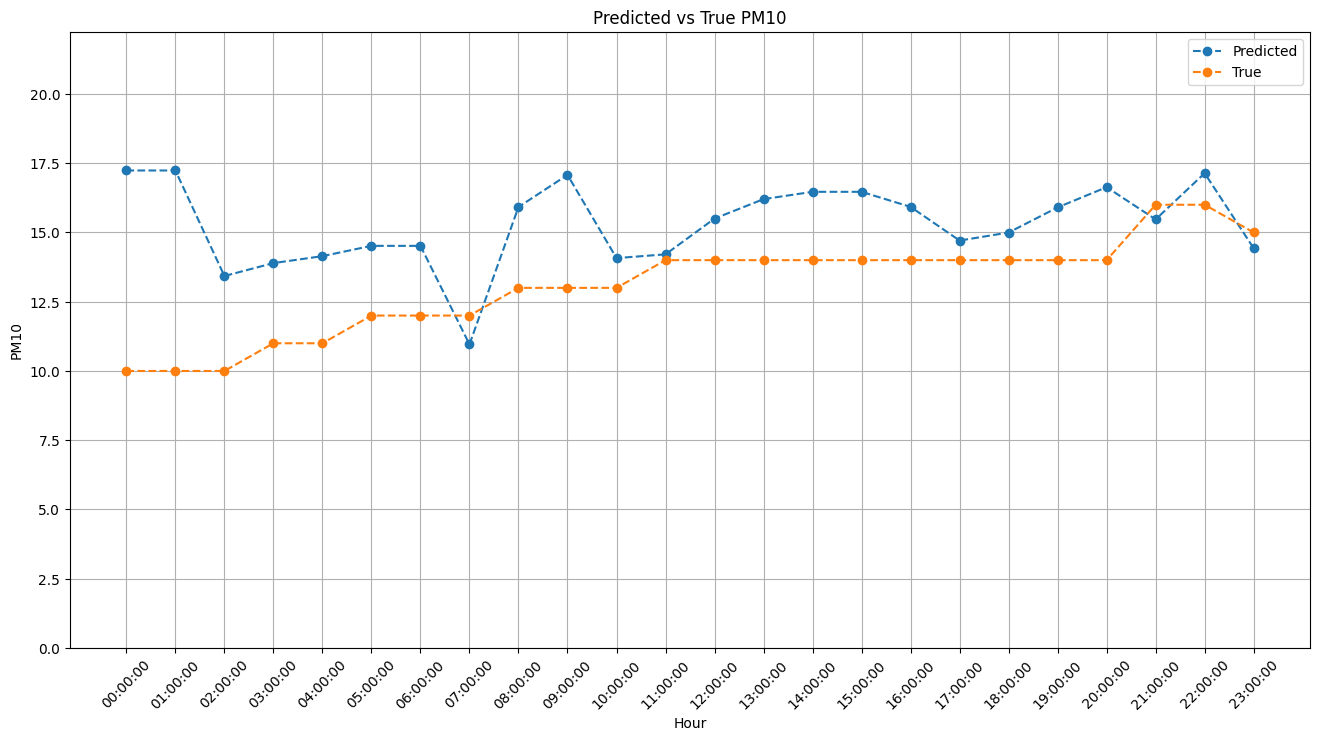

In [64]:
#preds_list_eval plots
import matplotlib.pyplot as plt

station_idx = 3

hours = np.genfromtxt('./generated_data/pivot_PM10_eval.csv', delimiter=',', usecols=0, dtype=str, skip_header=1)

#size
plt.figure(figsize=(16,8))
#title
plt.title('Predicted vs True PM10')
#labels
plt.xlabel('Hour')
plt.ylabel('PM10')
#plot
plt.plot(hours, preds_list_eval[:,station_idx], 'o--', label='Predicted')
plt.plot(hours, outs_list_eval[:,station_idx], 'o--', label='True')
#ylim
plt.ylim(0, max(preds_list_eval[:,station_idx])+5)
plt.legend()
#grid
plt.grid()

# Rotate x-axis labels by 45 degrees
plt.xticks(rotation=45)

plt.show()


C:\Users\wpietron\AppData\Local\Temp\ipykernel_32032\3539540682.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(hours, rotation=45, ha='right')


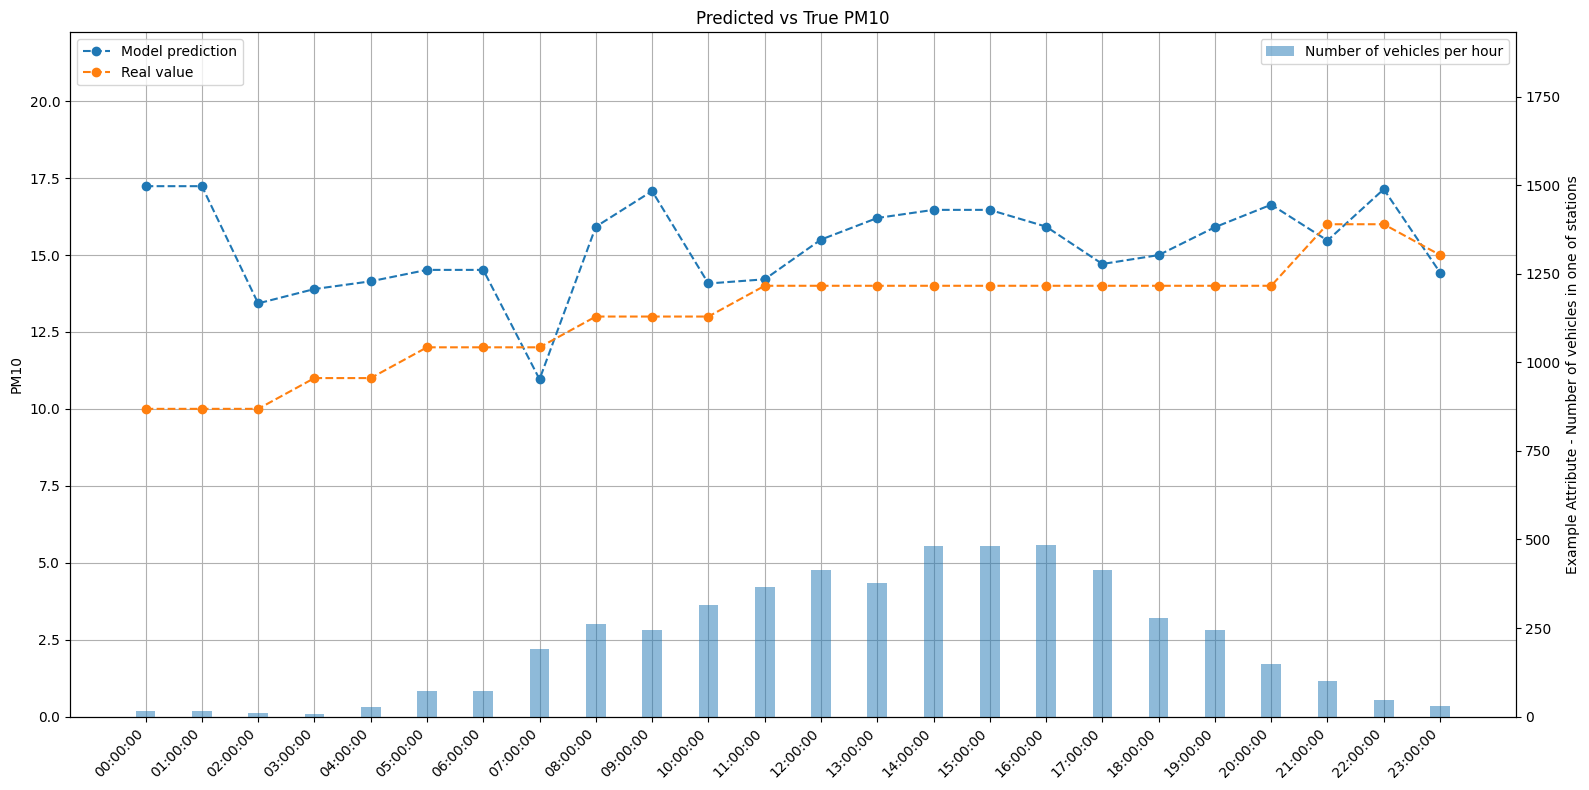

In [65]:
#preds_list_eval plots
import matplotlib.pyplot as plt

station_idx = 3

hours = np.genfromtxt('./generated_data/pivot_PM10_eval.csv', delimiter=',', usecols=0, dtype=str, skip_header=1)

choosen_attr = 10
attr = np.genfromtxt('./generated_data/pivot_traffic_eval.csv', delimiter=',', usecols=choosen_attr, dtype=float, skip_header=1)

# Create figure and primary Axes
fig, ax1 = plt.subplots(figsize=(16, 8))

# Create secondary Axes
ax2 = ax1.twinx()

# Plot lines on primary Axes
ax1.plot(hours, preds_list_eval[:,station_idx], 'o--', label='Model prediction')
ax1.plot(hours, outs_list_eval[:,station_idx], 'o--', label='Real value')
ax1.set_ylabel('PM10')

# Plot bars on secondary Axes
bar_width = 0.35
ax2.bar(hours, attr, width=bar_width, align='center', alpha=0.5, label='Number of vehicles per hour')
# ax2.bar(hours, outs_list_eval[:,station_idx], width=bar_width, align='center', alpha=0.5, label='Attribute')
ax2.set_ylabel('Example Attribute - Number of vehicles in one of stations')

# Set ylim for both y-axes
ax1.set_ylim(0, max(preds_list_eval[:,station_idx])+5)
ax2.set_ylim(0, 4*max(attr))

# Rotate x-axis labels by 45 degrees on primary Axes
ax1.set_xticklabels(hours, rotation=45, ha='right')

# Show legend
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show grid
ax1.grid()

plt.title('Predicted vs True PM10')

plt.tight_layout()  # Adjust layout to accommodate rotated labels

plt.show()


In [66]:
#calculate the mean absolute error for every output
from sklearn.metrics import mean_absolute_error

mean_abs_error_list = []
for i in range(output_size):
    mean_abs_error = mean_absolute_error(outs_list[:,i], preds_list[:,i])
    mean_abs_error_list.append(mean_abs_error)

print(mean_abs_error_list)

[3.5184557, 3.0965686, 3.546021, 3.40606, 3.2844682, 3.9319634, 4.342476, 4.4837213, 3.9169776, 4.5600796]
